In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import time
import numpy as np
import pandas as pd
import scipy.io as sio
from IPython.display import display

import matplotlib.pyplot as plt
import pywt
import scipy.stats

import datetime as dt
from collections import defaultdict, Counter

In [0]:

import pywt
print(pywt.families(short=False))


['Haar', 'Daubechies', 'Symlets', 'Coiflets', 'Biorthogonal', 'Reverse biorthogonal', 'Discrete Meyer (FIR Approximation)', 'Gaussian', 'Mexican hat wavelet', 'Morlet wavelet', 'Complex Gaussian wavelets', 'Shannon wavelets', 'Frequency B-Spline wavelets', 'Complex Morlet wavelets']


## Wavelet types etc/ not important

## Reading UCI-HAR

In [0]:
activities_description = {
    1: 'walking',
    2: 'walking upstairs',
    3: 'walking downstairs',
    4: 'sitting',
    5: 'standing',
    6: 'laying'
}

def signal_reader(filename):
    with open(filename, 'r') as fp:
        d = fp.read().splitlines()
        d = map(lambda x: x.rstrip().lstrip().split(), d)
        d = [list(map(float, line)) for line in d]
    return d

def label_reader(filename):        
    with open(filename, 'r') as fp:
        act = fp.read().splitlines()
        act = list(map(int, act))
    return act

def randomizer(dataset, labels):
    p = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[p, :, :]
    shuffled_labels = labels[p]
    return shuffled_dataset, shuffled_labels

train_fold = '/content/drive/My Drive/UCI HAR Dataset-Full/train/Inertial Signals/'
test_fold = '/content/drive/My Drive/UCI HAR Dataset-Full/test/Inertial Signals/'

train = ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 
                     'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt',
                     'total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']

test = ['body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt', 
                     'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt',
                     'total_acc_x_test.txt', 'total_acc_y_test.txt', 'total_acc_z_test.txt']

train_y_files = '/content/drive/My Drive/UCI HAR Dataset-Full/train/y_train.txt'
test_y_files = '/content/drive/My Drive/UCI HAR Dataset-Full/test/y_test.txt'

arr_train_signals, arr_test_signals = [], []

for inp_file in train:
    signal = signal_reader(train_fold + inp_file)
    arr_train_signals.append(signal)
arr_train_signals = np.transpose(np.array(arr_train_signals), (1, 2, 0))

for inp_file in test:
    signal = signal_reader(test_fold + inp_file)
    arr_test_signals.append(signal)
arr_test_signals = np.transpose(np.array(arr_test_signals), (1, 2, 0))

labels_train = label_reader(train_y_files)
labels_test = label_reader(test_y_files)

[no_signals_train, no_steps_train, no_components_train] = np.shape(arr_train_signals)
[no_signals_test, no_steps_test, no_components_test] = np.shape(arr_train_signals)
no_labels = len(np.unique(labels_train[:]))

print("The train  has {} signals, each one of length {} and {} components ".format(no_signals_train, no_steps_train, no_components_train))
print("The test  has {} signals, each one of length {} and {} components ".format(no_signals_test, no_steps_test, no_components_test))
print("The train  has {} labels, with the following distribution:\n {}".format(np.shape(labels_train)[0], Counter(labels_train[:])))
print("The test  has {} labels, with the following distribution:\n {}".format(np.shape(labels_test)[0], Counter(labels_test[:])))

x_train, y_train = randomizer(arr_train_signals, np.array(labels_train))
x_test, y_test = randomizer(arr_test_signals, np.array(labels_test))

The train dataset contains 7352 signals, each one of length 128 and 9 components 
The test dataset contains 7352 signals, each one of length 128 and 9 components 
The train dataset contains 7352 labels, with the following distribution:
 Counter({6: 1407, 5: 1374, 4: 1286, 1: 1226, 2: 1073, 3: 986})
The test dataset contains 2947 labels, with the following distribution:
 Counter({6: 537, 5: 532, 1: 496, 4: 491, 2: 471, 3: 420})


In [0]:
print(np.array(train_signals).shape)
print(np.array(test_signals).shape)

(7352, 128, 9)
(2947, 128, 9)


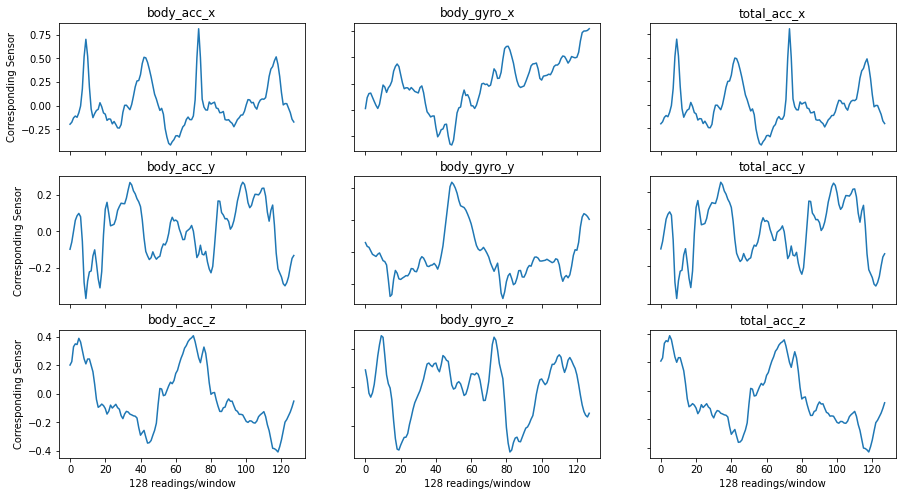

In [0]:
one_sample=train_signals[7351] # Any random val

fig, axs = plt.subplots(3, 3,figsize=(15,8))
axs[0, 0].plot(one_sample[:,0])
axs[0, 0].set_title('body_acc_x')

axs[1, 0].plot(one_sample[:,1])
axs[1, 0].set_title('body_acc_y')

axs[2, 0].plot(one_sample[:,2])
axs[2, 0].set_title('body_acc_z')

axs[0, 1].plot(one_sample[:,3])
axs[0, 1].set_title('body_gyro_x')

axs[1, 1].plot(one_sample[:,4])
axs[1, 1].set_title('body_gyro_y')

axs[2, 1].plot(one_sample[:,5])
axs[2, 1].set_title('body_gyro_z')

axs[0, 2].plot(one_sample[:,6])
axs[0, 2].set_title('total_acc_x')

axs[1, 2].plot(one_sample[:,7])
axs[1, 2].set_title('total_acc_y')

axs[2, 2].plot(one_sample[:,8])
axs[2, 2].set_title('total_acc_z')

for ax in axs.flat:
    ax.set(xlabel='128 readings/window', ylabel='Corresponding Sensor')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

## Feature Extraction with CWT

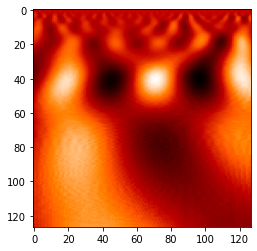

In [0]:
# Example execution of cwt.
scales = range(1,128)
waveletname = 'morl'
train_size = 1

sample_cwt= np.ndarray(shape=(1, 127, 127, 9)) #Çünkü kaç scale varsa o kadar dimension ekleniyor.
for j in range(0,9):
  signal = uci_har_signals_train[0, :, j] # I used first sample as an example
  coeff, freq = pywt.cwt(signal, scales, waveletname, 1) # Tam olarak bu satır cwt'yi execute ediyor.
  coeff_ = coeff[:,:127]
  sample_cwt[0, :, :, j] = coeff_ # Sonra coefficientleri topluyoruz

plt.imshow(np.squeeze(sample_cwt)[:,:,3], cmap='gist_heat')



Label is :  5


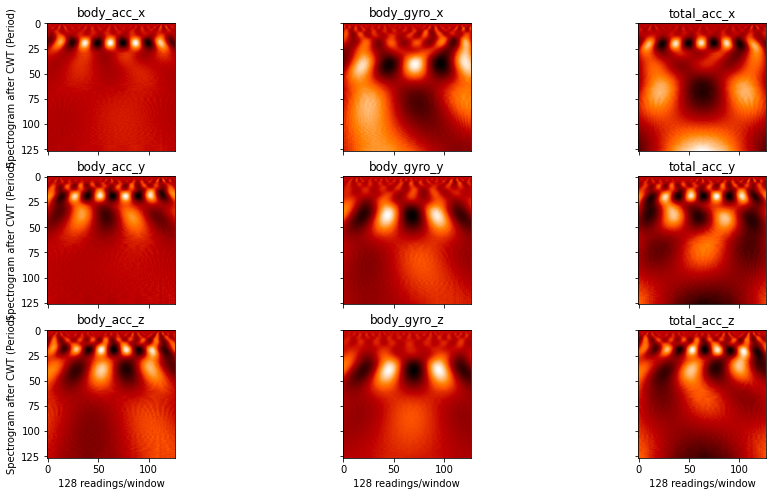

In [0]:
fig, axs = plt.subplots(3, 3,figsize=(15,8))
axs[0, 0].imshow(np.squeeze(sample_cwt)[:,:,0], cmap='gist_heat')
axs[0, 0].set_title('body_acc_x')

axs[1, 0].imshow(np.squeeze(sample_cwt)[:,:,1], cmap='gist_heat')
axs[1, 0].set_title('body_acc_y')

axs[2, 0].imshow(np.squeeze(sample_cwt)[:,:,2], cmap='gist_heat')
axs[2, 0].set_title('body_acc_z')

axs[0, 1].imshow(np.squeeze(sample_cwt)[:,:,3], cmap='gist_heat')
axs[0, 1].set_title('body_gyro_x')

axs[1, 1].imshow(np.squeeze(sample_cwt)[:,:,4], cmap='gist_heat')
axs[1, 1].set_title('body_gyro_y')

axs[2, 1].imshow(np.squeeze(sample_cwt)[:,:,5], cmap='gist_heat')
axs[2, 1].set_title('body_gyro_z')

axs[0, 2].imshow(np.squeeze(sample_cwt)[:,:,6], cmap='gist_heat')
axs[0, 2].set_title('total_acc_x')

axs[1, 2].imshow(np.squeeze(sample_cwt)[:,:,7], cmap='gist_heat')
axs[1, 2].set_title('total_acc_y')

axs[2, 2].imshow(np.squeeze(sample_cwt)[:,:,8], cmap='gist_heat')
axs[2, 2].set_title('total_acc_z')

for ax in axs.flat:
    ax.set(xlabel='128 readings/window', ylabel='Spectrogram after CWT (Period)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

print("Label is : ", train_labels[0])




In [0]:
#Bu işlem bayağı bir costly ,  sonuçları drive'a save edilmesi lazım.

wavelet_scales = range(1,128)
name_wavelet = 'morl'
train_size = 7352
test_size=   1000
 
train_data_cwt = np.ndarray(shape=(train_size, 127, 127, 9)) #Çünkü kaç scale varsa o kadar dimension ekleniyor.
 
for i in range(0,train_size):
    for j in range(0,9):
        signal = uci_har_signals_train[i, :, j]
        coeff, freq = pywt.cwt(signal, wavelet_scales, name_wavelet, 1) # cwt execution
        coeff_ = coeff[:,:127]
        train_data_cwt[i, :, :, j] = coeff_ # adding coeffs then
 
test_data_cwt = np.ndarray(shape=(test_size, 127, 127, 9))
for i in range(0,test_size):
    for j in range(0,9):
        signal = uci_har_signals_test[i, :, j]
        coeff, freq = pywt.cwt(signal, wavelet_scales, name_wavelet, 1)
        coeff_ = coeff[:,:127]
        test_data_cwt[i, :, :, j] = coeff_
 
labels_train = list(map(lambda x: int(x) - 1, labels_train))
labels_test = list(map(lambda x: int(x) - 1, labels_test))
 
x_train = train_data_cwt
y_train = list(labels_train[:train_size])
x_test = test_data_cwt
y_test = list(labels_test[:test_size])

In [0]:
np.save('/content/drive/My Drive/UCI-HAR-PROCESSED/Xtrain_data_cwt.npy', x_train)    # .npy extension is added if not given
np.save('/content/drive/My Drive/UCI-HAR-PROCESSED/Ytrain_data_cwt.npy', y_train)    # .npy extension is added if not given
np.save('/content/drive/My Drive/UCI-HAR-PROCESSED/Xtest_data_cwt.npy', x_test)    # .npy extension is added if not given
np.save('/content/drive/My Drive/UCI-HAR-PROCESSED/Ytest_data_cwt.npy', y_test)    # .npy extension is added if not given


In [0]:
 X_train = np.load('/content/drive/My Drive/UCI-HAR-PROCESSED/Xtrain_data_cwt.npy')
 y_train=np.load('/content/drive/My Drive/UCI-HAR-PROCESSED/Ytrain_data_cwt.npy')
 X_test=np.load('/content/drive/My Drive/UCI-HAR-PROCESSED/Xtest_data_cwt.npy')
 y_test=np.load('/content/drive/My Drive/UCI-HAR-PROCESSED/Ytest_data_cwt.npy')

In [0]:
x_train=X_train
x_test=X_test

## Applying Conv Net

In [0]:
import keras

img_x = 127
img_y = 127
img_z = 9

input_shape = (img_x, img_y, img_z)

x_train = X_train.astype('float32')
x_test = X_test.astype('float32')
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

y_train = keras.utils.to_categorical(y_train, 6)
y_test = keras.utils.to_categorical(y_test, 6)


x_train shape: (7352, 127, 127, 9)
7352 train samples
1000 test samples


In [0]:
import keras
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import History,EarlyStopping 
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from keras import backend as K



def recall_m(true_Y, pred_Y):
        TP = K.sum(K.round(K.clip(true_Y * pred_Y, 0, 1)))
        possible_pos = K.sum(K.round(K.clip(true_Y, 0, 1)))
        rec = TP / (possible_pos + K.epsilon())
        return rec

def precision_m(true_Y, pred_Y):
        true_positives = K.sum(K.round(K.clip(true_Y * pred_Y, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(pred_Y, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(true_Y, pred_Y):
    pres = precision_m(true_Y, pred_Y)
    rec = recall_m(true_Y, pred_Y)
    return 2*((pres*rec)/(pres+rec+K.epsilon()))

### CNN functional

In [0]:
from keras.layers import LSTM
from keras import Model

img_x = 127
img_y = 127
img_z = 9

class CNN(object):
  def __init__(self,
               class_num=6,
               last_activation='softmax'):

      self.class_num = 6
      self.last_activation = last_activation

  def forward(self):
    
      img_inputs  = keras.Input((img_x,img_y,img_z))
      conv_1 = keras.layers.Conv2D(32, (5, 5), activation='relu', strides=(1, 1))(img_inputs)
      maxpool_1 = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(conv_1)

      conv_2 = keras.layers.Conv2D(64, (5, 5), activation='relu', strides=(2, 2))(maxpool_1)
      maxpool_2 = keras.layers.MaxPooling2D((2, 2))(conv_2)

      flatten = keras.layers.Flatten()(conv_2)
      dense_1 = keras.layers.Dense(512, activation='relu')(flatten)


      output = Dense(self.class_num, activation=self.last_activation)(dense_1)
      model = Model(inputs=img_inputs, outputs=output)
      return model


def CNN_train(X_train,y_train,X_test,y_test):
  
  history = History()

  num_classes = 6
  batch_size = 16
  epochs = 50
  early_stopping = [EarlyStopping(monitor='val_loss',min_delta=0,restore_best_weights=True, patience=7,verbose=1, mode='auto')]


  model=CNN().forward()
  model.compile(loss=keras.losses.categorical_crossentropy, 
                optimizer=keras.optimizers.Adam(), 
                metrics=['accuracy',f1_m,precision_m, recall_m])

  history=model.fit(X_train, y_train, batch_size=batch_size, 
            epochs=epochs, verbose=1, 
            validation_split=0.1, 
            callbacks=early_stopping)

  

  loss, accuracy, f1_score, precision, recall = model.evaluate(X_train, y_train, verbose=1)
  print(" CNN Training Loss: {:.4f}".format(loss))
  print(" CNN Training Accuracy: {:.4f}".format(accuracy))
  print(" CNN Training f1 score: {:.4f}".format(f1_score))
  print(" CNN Training Precision: {:.4f}".format(precision))
  print(" CNN Training Recall: {:.4f}".format(recall))


  loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=1)
  print(" CNN Test Loss: {:.4f}".format(loss))
  print(" CNN Test Accuracy: {:.4f}".format(accuracy))
  print(" CNN Test f1 score: {:.4f}".format(f1_score))
  print(" CNN Test Precision: {:.4f}".format(precision))
  print(" CNN Test Recall: {:.4f}".format(recall))


  test_score = model.evaluate(X_test, y_test, verbose=0)
  print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

  number_of_epochs_it_ran = len(history.history['accuracy'])

  fig, axarr = plt.subplots(figsize=(12,6), ncols=2)
  axarr[0].plot(range(1, number_of_epochs_it_ran+1), history.history['accuracy'], label='train score')
  axarr[0].plot(range(1, number_of_epochs_it_ran+1), history.history['val_accuracy'], label='test score')
  axarr[0].set_xlabel('Number of Epochs', fontsize=18)
  axarr[0].set_ylabel('Accuracy', fontsize=18)
  axarr[0].set_ylim([0,1])
  axarr[1].plot(range(1, number_of_epochs_it_ran+1), history.history['accuracy'], label='train score')
  axarr[1].plot(range(1, number_of_epochs_it_ran+1), history.history['val_accuracy'], label='test score')
  axarr[1].set_xlabel('Number of Epochs', fontsize=18)
  axarr[1].set_ylabel('Accuracy', fontsize=18)
  axarr[1].set_ylim([0.80,1])
  plt.legend()
  plt.show()


Train on 6616 samples, validate on 736 samples
Epoch 1/50
6616/6616 [==============================] - 8s 1ms/step - loss: 0.2974 - accuracy: 0.9018 - f1_m: 0.8954 - precision_m: 0.9081 - recall_m: 0.8892 - val_loss: 0.1756 - val_accuracy: 0.9321 - val_f1_m: 0.9310 - val_precision_m: 0.9329 - val_recall_m: 0.9293
Epoch 2/50
6616/6616 [==============================] - 8s 1ms/step - loss: 0.1526 - accuracy: 0.9407 - f1_m: 0.9407 - precision_m: 0.9415 - recall_m: 0.9401 - val_loss: 0.2210 - val_accuracy: 0.9049 - val_f1_m: 0.9037 - val_precision_m: 0.9067 - val_recall_m: 0.9008
Epoch 3/50
6616/6616 [==============================] - 8s 1ms/step - loss: 0.1445 - accuracy: 0.9479 - f1_m: 0.9478 - precision_m: 0.9492 - recall_m: 0.9466 - val_loss: 0.7986 - val_accuracy: 0.8777 - val_f1_m: 0.8753 - val_precision_m: 0.8784 - val_recall_m: 0.8723
Epoch 4/50
6616/6616 [==============================] - 8s 1ms/step - loss: 0.2226 - accuracy: 0.9400 - f1_m: 0.9392 - precision_m: 0.9407 - recall_m

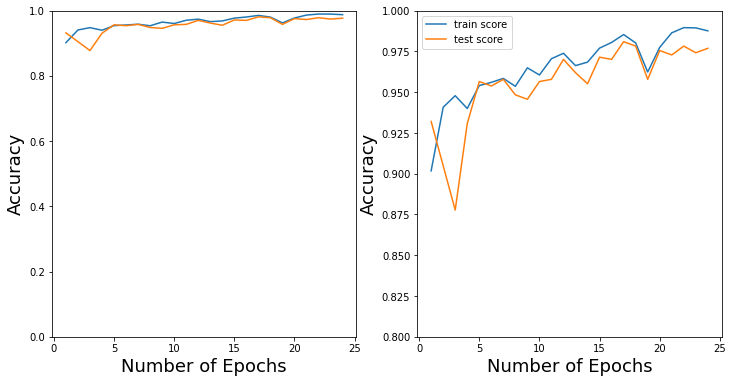

In [0]:
#batch,epoch,lr must be added to the function params.
history_cnnlstm=CNN_train(x_train,y_train,x_test,y_test)

### CNNLSTM

In [0]:
# calısan


from keras.layers import LSTM,Lambda,TimeDistributed
from keras import Model

img_x = 127
img_y = 127
img_z = 9

class CNN(object):
  def __init__(self,
               class_num=6,
               last_activation='softmax'):

      self.class_num = 6
      self.last_activation = last_activation

  def forward(self):
    

      
      #maxpool_2 = Lambda(lambda y: keras.backend.squeeze(y, 0))(maxpool_2)

      #flatten = keras.layers.Flatten()(maxpool_2)


      img_inputs  = keras.Input((img_x,img_y,img_z))
      
      #x = Lambda(lambda y: keras.backend.squeeze(y, 0))(img_inputs)
      print("img_inputs", img_inputs.shape)

      
      conv_1 = keras.layers.Conv2D(32, (5, 5), activation='relu', strides=(1, 1))(img_inputs)
      maxpool_1 = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(conv_1)

      print("maxpool1",maxpool_1.shape)

      conv_2 = keras.layers.Conv2D(64, (5, 5), activation='relu', strides=(2, 2))(maxpool_1)
      maxpool_2 = keras.layers.MaxPooling2D((2, 2))(conv_2)

      #flatten = keras.layers.Flatten()(maxpool_2)

      print("maxpool2",maxpool_2.shape)

      #reshaped = Lambda(lambda y: keras.backend.squeeze(y, 0))(maxpool_1)
      
      reshaped = Lambda(lambda y: keras.backend.reshape(y, (-1,14*14,64)))(maxpool_2) #Burasına shape'i maxppool2.shape[1]**2 tarzı bir şey olucak. bunu düzelt.

      #reshaped=keras.backend.reshape(maxpool_1, (-1,61*61,32))
      print(reshaped.shape, "reshaped")
      
      x=LSTM(61, return_sequences=False)(reshaped) 
      
      print(x.shape, "lstm")

      #x=Lambda(lambda y: keras.backend.expand_dims(x, 0))(x)

      #x = keras.backend.expand_dims(x, axis=0)

      #x = keras.layers.Flatten()(x)

      #Iputs needs to be reshaped to be [samples, time steps, features]



      print("flatten",x.shape)

      dense_1 = keras.layers.Dense(32, activation='relu')(x)
      
      print("dense_out",dense_1.shape)

      #dense_1 = Lambda(lambda y: keras.backend.squeeze(y, 0))(dense_1)


      #dense_1=keras.backend.reshape(dense_1, (None,32))
      print("ok")
      output = Dense(self.class_num, activation=self.last_activation)(dense_1)
      print("output",output.shape)
 
      model = Model(inputs=img_inputs, outputs=output)

      #print(keras.backend.squeeze(maxpool_2,0))
      #maxpool_2=keras.backend.squeeze(maxpool_2,0)
      #maxpool_2 = Lambda(lambda y: keras.backend.squeeze(y, 0))(maxpool_2)

      #x = LSTM(128, return_sequences=False)(flatten)  # LSTM or GRU
      #print("x:", x.shape)

      return model


def CNN_train(X_train,y_train,X_test,y_test):
  
  history = History()

  num_classes = 6
  batch_size = 64
  epochs = 50
  early_stopping = [EarlyStopping(monitor='val_loss',min_delta=0,restore_best_weights=True, patience=7,verbose=1, mode='auto')]
 


  model=CNN().forward()
  model.compile(loss=keras.losses.categorical_crossentropy, 
                optimizer=keras.optimizers.Adam(), 
                metrics=['accuracy',f1_m,precision_m, recall_m])

  history=model.fit(X_train, y_train, batch_size=batch_size, 
            epochs=epochs, verbose=1, 
            validation_split=0.1, 
            callbacks=early_stopping)

  

  loss, accuracy, f1_score, precision, recall = model.evaluate(X_train, y_train, verbose=1)
  print(" CNN Training Loss: {:.4f}".format(loss))
  print(" CNN Training Accuracy: {:.4f}".format(accuracy))
  print(" CNN Training f1 score: {:.4f}".format(f1_score))
  print(" CNN Training Precision: {:.4f}".format(precision))
  print(" CNN Training Recall: {:.4f}".format(recall))


  loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=1)
  print(" CNN Test Loss: {:.4f}".format(loss))
  print(" CNN Test Accuracy: {:.4f}".format(accuracy))
  print(" CNN Test f1 score: {:.4f}".format(f1_score))
  print(" CNN Test Precision: {:.4f}".format(precision))
  print(" CNN Test Recall: {:.4f}".format(recall))


  test_score = model.evaluate(X_test, y_test, verbose=0)
  print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

  number_of_epochs_it_ran = len(history.history['accuracy'])

  fig, axarr = plt.subplots(figsize=(12,6), ncols=2)
  axarr[0].plot(range(1, number_of_epochs_it_ran+1), history.history['accuracy'], label='train score')
  axarr[0].plot(range(1, number_of_epochs_it_ran+1), history.history['val_accuracy'], label='test score')
  axarr[0].set_xlabel('Number of Epochs', fontsize=18)
  axarr[0].set_ylabel('Accuracy', fontsize=18)
  axarr[0].set_ylim([0,1])
  axarr[1].plot(range(1, number_of_epochs_it_ran+1), history.history['accuracy'], label='train score')
  axarr[1].plot(range(1, number_of_epochs_it_ran+1), history.history['val_accuracy'], label='test score')
  axarr[1].set_xlabel('Number of Epochs', fontsize=18)
  axarr[1].set_ylabel('Accuracy', fontsize=18)
  axarr[1].set_ylim([0.80,1])
  plt.legend()
  plt.show()


img_inputs (None, 127, 127, 9)
maxpool1 (None, 61, 61, 32)
maxpool2 (None, 14, 14, 64)
(None, 196, 64) reshaped
(None, 61) lstm
flatten (None, 61)
dense_out (None, 32)
ok
output (None, 6)
Train on 6616 samples, validate on 736 samples
Epoch 1/50
6616/6616 [==============================] - 32s 5ms/step - loss: 0.7131 - accuracy: 0.7364 - f1_m: 0.6502 - precision_m: 0.7303 - recall_m: 0.6090 - val_loss: 0.4936 - val_accuracy: 0.8193 - val_f1_m: 0.8055 - val_precision_m: 0.8288 - val_recall_m: 0.7839
Epoch 2/50
6616/6616 [==============================] - 32s 5ms/step - loss: 0.3588 - accuracy: 0.8676 - f1_m: 0.8670 - precision_m: 0.8814 - recall_m: 0.8534 - val_loss: 0.3597 - val_accuracy: 0.8655 - val_f1_m: 0.8578 - val_precision_m: 0.8713 - val_recall_m: 0.8451
Epoch 3/50
6616/6616 [==============================] - 33s 5ms/step - loss: 0.2850 - accuracy: 0.8980 - f1_m: 0.8983 - precision_m: 0.9062 - recall_m: 0.8906 - val_loss: 0.2388 - val_accuracy: 0.9171 - val_f1_m: 0.9203 - val_p

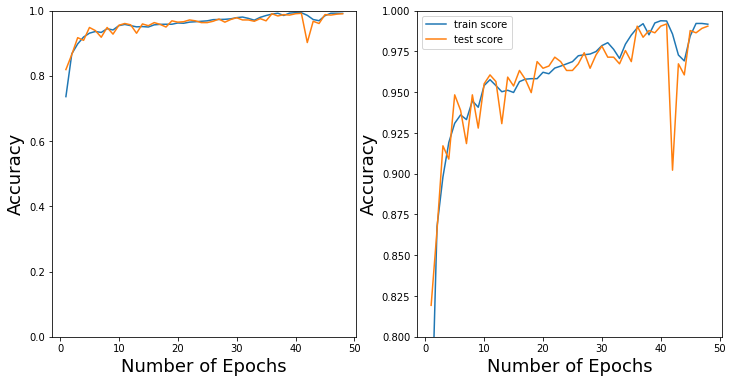

In [0]:
#batch,epoch,lr must be added to the function params.
history_cnnlstm=CNN_train(x_train,y_train,x_test,y_test)